In [1]:
import os
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [2]:
HOME_DIR = "/mnt/ibm_lg/angela/sapiens/"

In [3]:
# HOME_DIR = '/data/yosef2/users/chenling/TabulaSapiensData/NewPilots/'

In [5]:
pwd

'/data/angela/sapiens/tabula-sapiens/analysis-scripts'

In [4]:
adata = sc.read_h5ad(HOME_DIR + 'TSP1_TSP15_10X_smartseq2_filtered_deduped_decontX_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes'
    var: 'gene_symbol', 'feature_type', 'ensemblid'
    layers: 'decontXcounts', 'raw_counts'

In [5]:
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes'
    var: 'gene_symbol', 'feature_type', 'ensemblid'
    layers: 'decontXcounts', 'raw_counts'

In [6]:
set(adata.obs['donor'])

{'TSP1',
 'TSP10',
 'TSP11',
 'TSP12',
 'TSP13',
 'TSP14',
 'TSP15',
 'TSP2',
 'TSP3',
 'TSP4',
 'TSP5',
 'TSP6',
 'TSP7',
 'TSP8',
 'TSP9'}

In [7]:
def run_scvi(
    adata,
    n_latent=50,
    n_layers=3,
    dropout_rate=0.1,
    dispersion="gene",
    max_epochs=None,
    batch_size=1024,
    pretrained_scvi_path=None,
    var_subset_type="inner_join",
    obsm_latent_key="X_scvi",
    save_folder=None,
    overwrite=True,
    save_anndata=False,
):
    training_mode = adata.uns["_training_mode"]
    if training_mode == "online" and pretrained_scvi_path is None:
        raise ValueError("online training but no pretrained_scvi_path passed in.")

    if training_mode == "offline":
        model = scvi.model.SCVI(
            adata,
            n_latent=n_latent,
            n_layers=n_layers,
            dropout_rate=dropout_rate,
            dispersion=dispersion,
            use_layer_norm="both",
            use_batch_norm="none",
            encode_covariates=True,
        )
        print("Training scvi offline.")

    elif training_mode == "online":
        if max_epochs is None:
            n_cells = adata.n_obs
            max_epochs = np.min([round((20000 / n_cells) * 200), 200])

        query = adata[adata.obs["_dataset"] == "query"].copy()
        model = scvi.model.SCVI.load_query_data(query, pretrained_scvi_path)
        print("Training scvi online.")

    model.train(max_epochs=max_epochs, train_size=1.0, batch_size=batch_size)
    adata.obsm[obsm_latent_key] = model.get_latent_representation(adata)
    
    sc.pp.neighbors(adata, use_rep=obsm_latent_key)
    sc.tl.umap(adata)
    adata.obsm[obsm_latent_key+'_umap'] = adata.obsm['X_umap']
    del adata.obsm['X_umap']
    
    if save_folder is not None:
        model.save(save_folder, overwrite=overwrite, save_anndata=save_anndata)


In [8]:
adata.layers['decontXcounts'].data = np.round(adata.layers['decontXcounts'].data)

In [9]:
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes'
    var: 'gene_symbol', 'feature_type', 'ensemblid'
    layers: 'decontXcounts', 'raw_counts'

In [30]:
adata.var.tail()

,gene_symbol,feature_type,ensemblid,highly_variable,means,dispersions,dispersions_norm,mean,std
MT-ND6,MT-ND6,Gene Expression,ENSG00000198695.2,False,0.963484,2.466404,0.154140,0.590065,0.741395
MT-TE,MT-TE,Gene Expression,ENSG00000210194.1,False,0.160067,1.603787,-0.044396,0.083929,0.301820
MT-CYB,MT-CYB,Gene Expression,ENSG00000198727.2,False,4.367693,4.765751,-0.499747,3.874830,1.104192
MT-TT,MT-TT,Gene Expression,ENSG00000210195.2,False,0.065740,0.624316,-0.719108,0.040580,0.186848
MT-TP,MT-TP,Gene Expression,ENSG00000210196.2,True,0.438510,2.705558,1.115482,0.204806,0.501265


In [10]:
scvi.data.setup_anndata(
    adata, batch_key="donor_method", layer="decontXcounts"
)
adata.uns["_training_mode"] = 'offline'


INFO     Using batches from adata.obs["donor_method"]                                        
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["decontXcounts"]                                       
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 503886 cells, 58870 vars, 27      
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [11]:
run_scvi(
    adata,
    max_epochs=None,
    n_latent=50,
    dropout_rate=0.1,
    dispersion = "gene-batch",
    obsm_latent_key = 'X_scvi',
    save_folder=HOME_DIR + "TSP1_TSP15_decontX"
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Training scvi offline.
Epoch 16/16: 100%|██████████| 16/16 [59:17<00:00, 222.32s/it, loss=7.84e+03, v_num=1]


In [12]:
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_symbol', 'feature_type', 'ensemblid'
    uns: '_scvi', '_training_mode', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_scvi_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'distances', 'connectivities'

In [13]:
adata.obsm['X_umap'] = adata.obsm['X_scvi_umap']

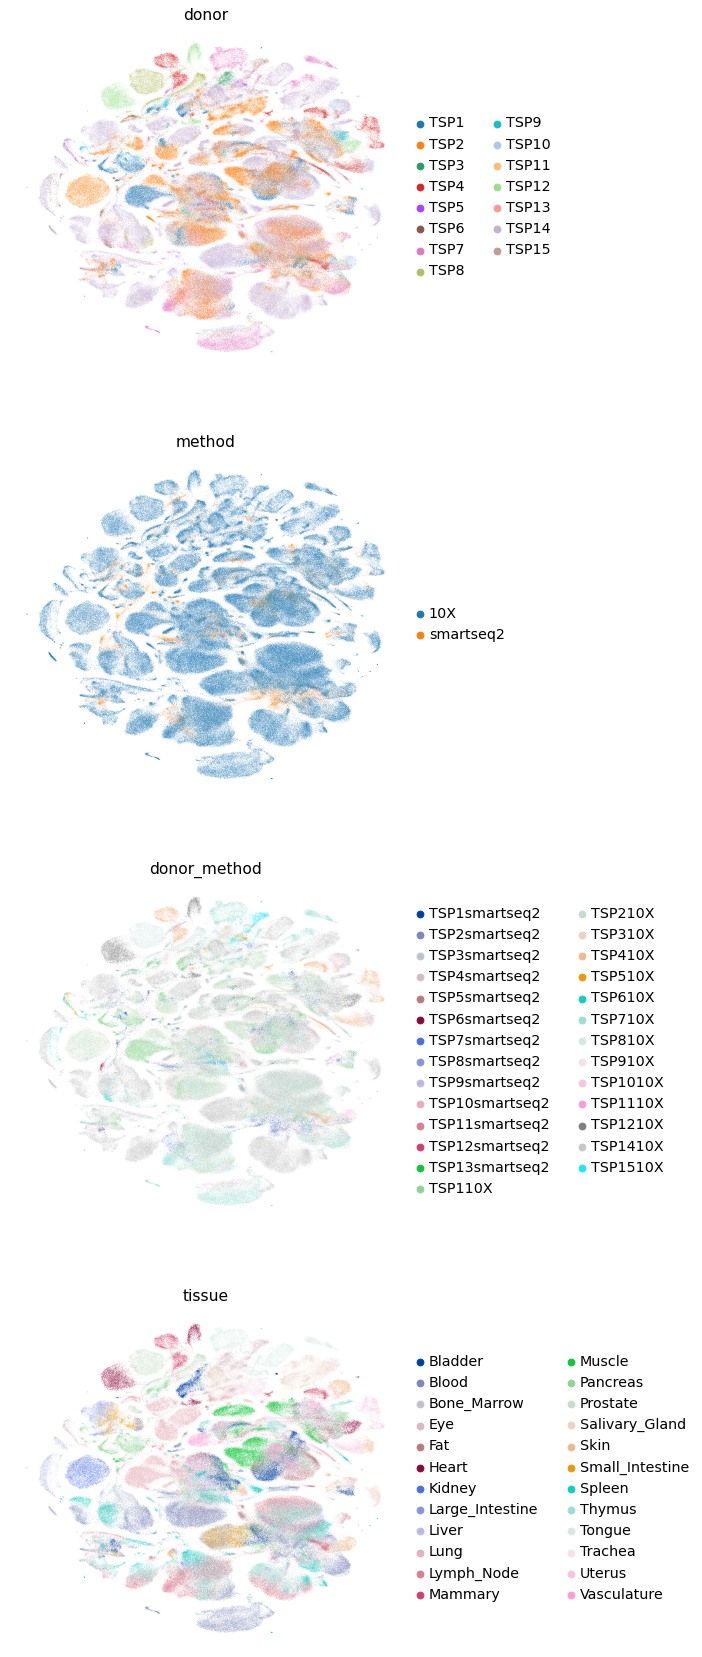

In [14]:
sc.pl.umap(adata,color=['donor','method','donor_method','tissue'],ncols=1, save = "_TSP1_TSP15_scvi.pdf")

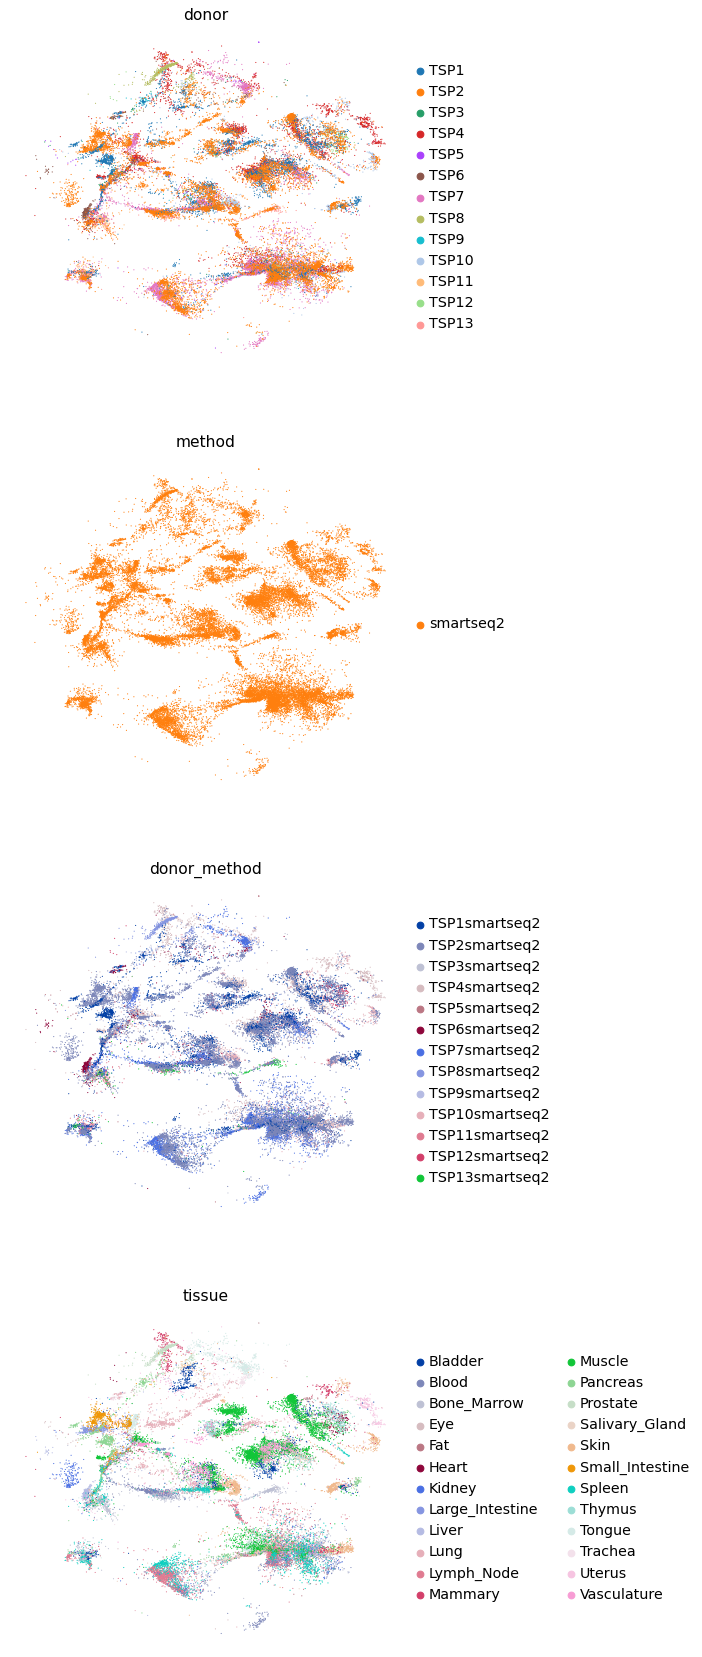

In [15]:
sc.pl.umap(adata[adata.obs['method']=='smartseq2'],color=['donor','method','donor_method','tissue'],ncols=1)

In [16]:
HOME_DIR

'/mnt/ibm_lg/angela/sapiens/'

In [17]:
adata.write(HOME_DIR+"TSP1_TSP15_scvi_donor-method.h5ad")

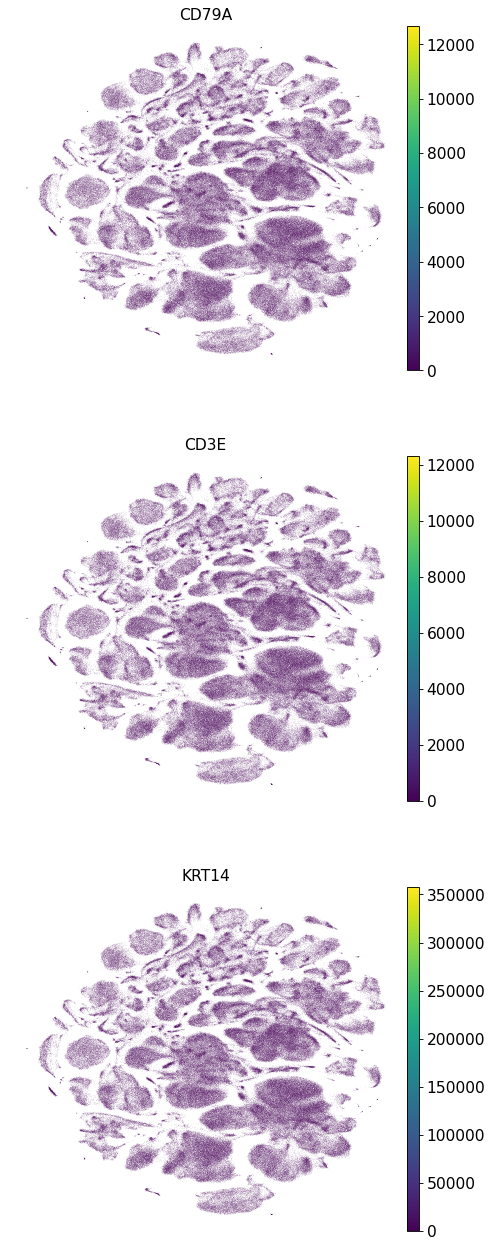

In [18]:
sc.pl.umap(adata,color=['CD79A','CD3E','KRT14'],ncols=1)

In [19]:
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_symbol', 'feature_type', 'ensemblid'
    uns: '_scvi', '_training_mode', 'neighbors', 'umap', 'donor_colors', 'method_colors', 'donor_method_colors', 'tissue_colors'
    obsm: 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'distances', 'connectivities'

In [20]:
print('normalization & scaling')

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10, zero_center=False)

normalization & scaling


In [29]:
adata.write(HOME_DIR+"TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled.h5ad")

In [25]:
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'neighbors', 'umap', 'donor_colors', 'method_colors', 'donor_method_colors', 'tissue_colors', 'log1p', 'hvg'
    obsm: 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'distances', 'connectivities'

In [28]:
adata.X.min()

0.0

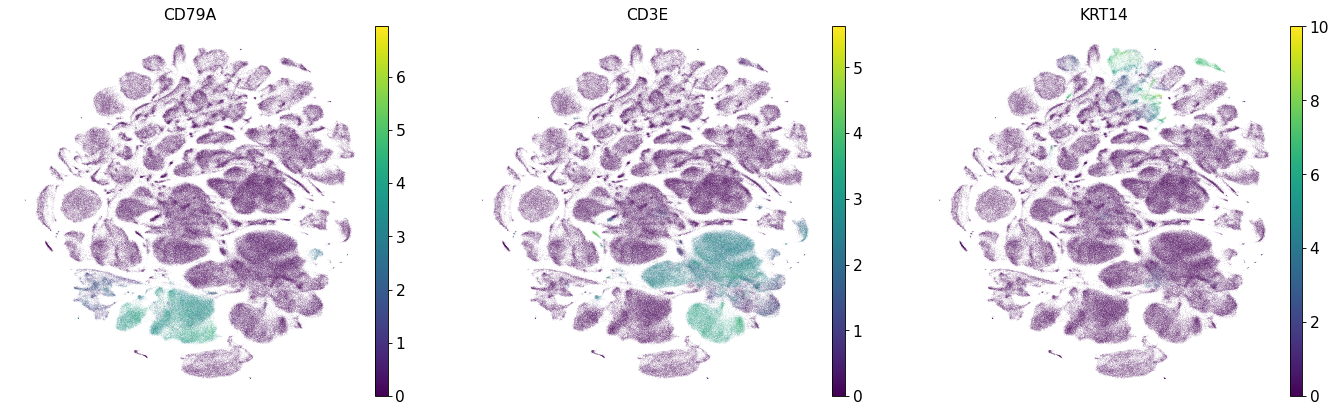

In [22]:
sc.pl.umap(adata,color=['CD79A','CD3E','KRT14'],use_raw=False)

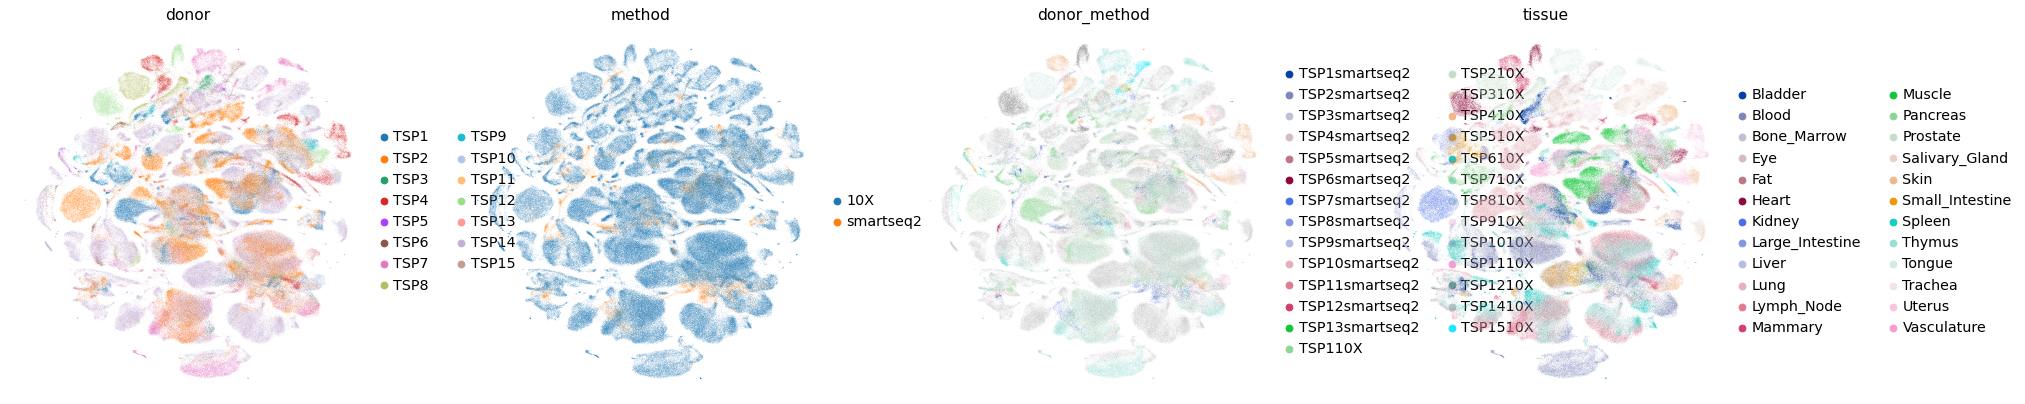

In [24]:
sc.pl.umap(adata,color=['donor','method','donor_method','tissue'],use_raw=False)

In [ ]:
adata.var_names[adata.var_names.str.startswith("AP002956")]

In [ ]:
adata.var_names.shape

In [ ]:
adata_copy = adata.copy()

In [ ]:
adata_copy.var_names = list(adata_copy.var['ensemblid-0-0-0'])


In [ ]:
adata_copy.var_names[adata_copy.var_names.str.startswith("ENSG00000076706")]

In [ ]:
adata_copy.var.loc['ENSG00000076706.17']

In [3]:
adata = sc.read_h5ad(HOME_DIR+"TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled.h5ad")
adata

AnnData object with n_obs × n_vars = 503886 × 58870
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'cell_identifier', 'decontX_split', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
sc.tl.umap(adata, n_components=3)
adata.obsm['X_scvi_umap_3d'] = adata.obsm['X_umap']